<summary>Table of Contents</summary>

- [1. UTC to local time](#1-utc-to-local-time)
- [2. Split and scale data](#2-split-and-scale-data)



Here we split the whole dataset into 5 datasets for each country (now they contain only their country related columns). In addition we **truncate outliers** and scale the data (for ARIMA, because other models do that within the code). We perform scaling here to analyse the values. In such a way we can then choose appropriate evaluation metrics etc.

# 1. UTC to local time

In [21]:
import pandas as pd
import numpy as np
import os
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from utils.helper import split_scale_dataset

In [22]:
# Create a folder named "datasets" if it doesn't exist
folder_name = "datasets"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

df = pd.read_csv("./datasets/top_5_countries.csv", index_col=0, parse_dates=True)

For each country revert UTC time to local time. Then make so that each dataset starts and ends at the same time.

In [23]:
top_5_countries = ['DE', 'GB', 'ES', 'FR', 'IT']
utc_converter = {'DE': 'Europe/Berlin', 
                 'GB': 'Europe/London', 
                 'ES': 'Europe/Madrid', 
                 'FR': 'Europe/Paris', 
                 'IT': 'Europe/Rome'}

# Split and save the datasets
for country_prefix in top_5_countries:
    # Filter columns with the specified prefix
    country_columns = [col for col in df.columns if col.startswith(country_prefix)]
    country_df = df[country_columns].copy()

    # Convert UTC to local time
    country_df.index = country_df.index.tz_convert(utc_converter[country_prefix]).tz_localize(None)
    
    # We drop first day and last day, because of missing values
    first_day = country_df.index.date.min()
    last_day = date(2020, 9, 30)

    # Drop all observations from the first and last days
    country_df = country_df[(country_df.index.date > first_day) & (country_df.index.date < last_day)]

    # Make 24 hours in each day (after daylight savings time etc) we have 23/25 hours
    # in other words - irregular intervals.
    # We will change it to have 24 hours in each day (simplest method). Then we do not break 
    # seasonalities and patterns, because at night load is small.
    # Time changes: https://stats.stackexchange.com/questions/45046/daylight-saving-time-in-time-series-modelling-e-g-load-data
    
    # Remove duplicated timestamps
    country_df = country_df[~country_df.index.duplicated(keep='first')]

    # Resample to hourly frequency to ensure all hours are included
    country_df = country_df.resample('H').asfreq()

    # Fill missing values with average of the previous and next value
    country_df = country_df.interpolate(method='linear', limit=1)
    
    # Save the DataFrame to a CSV file
    file_name = f"./datasets/{country_prefix}_data.csv"
    country_df.to_csv(file_name)

# 2. Split and scale data

Because of summer and winter time changes, we have not full days now.

In [24]:
de_df, gb_df, es_df, fr_df, it_df = [pd.read_csv(f"./datasets/{country}_data.csv", index_col=0, parse_dates=True) for country in top_5_countries] 

In [25]:
for df_country in [de_df, gb_df, es_df, fr_df, it_df]: 
    print(len(df_country))
del df_country

41616
41616
41616
41616
41616


In [26]:
# Check whether our data preparation was correct
# There were different indices in the datasets
# Because Britain has British summer time, others Central European summer time
# British: change time from 01:00 to 02:00
# Central European: change time from 02:00 to 03:00
# Source: https://www.timeanddate.com/time/europe/

if de_df.index.isin(gb_df.index).all():
    print("Indices are identical!")
else:
    print("Indices are not identical...")

    # Find non-matching elements
    non_matching_elements_in_de_df = de_df.index[~de_df.index.isin(gb_df.index)]
    non_matching_elements_in_gb_df = gb_df.index[~gb_df.index.isin(de_df.index)]
    print("Non-matching elements in de_df:", non_matching_elements_in_de_df)
    print("Non-matching elements in gb_df:", non_matching_elements_in_gb_df)

Indices are identical!


In [27]:
# days in the datasets
for df_country in [de_df, gb_df, es_df, fr_df, it_df]:
    days_in_data = len(df_country)/24
    print(f'{days_in_data:.0f} days in the dataset.')

del df_country

1734 days in the dataset.
1734 days in the dataset.
1734 days in the dataset.
1734 days in the dataset.
1734 days in the dataset.


In [28]:
# We combine dfs, because it will be easier to work with them
combined_df = pd.concat([de_df, gb_df, es_df, fr_df, it_df], axis=1)

print('Index frequency before:', combined_df.index.freq)

# Set frequency
combined_df = combined_df.asfreq('H')
print('Index frequency after:', combined_df.index.freq)

Index frequency before: None
Index frequency after: <Hour>


In [29]:
# Divide data into days

train_size = int(round(len(country_df)/24*0.7, 0))
test_size = int(round(len(country_df)/24*0.15, 0))
val_size = int(len(country_df)/24) - train_size - test_size
print(f'{train_size:.0f} days in the train dataset.\n {test_size:.0f} days in the test dataset.\n {val_size:.0f} days in the validation dataset.')

assert(days_in_data == train_size + test_size + val_size)

1214 days in the train dataset.
 260 days in the test dataset.
 260 days in the validation dataset.


In [30]:
num_train = train_size*24
num_test = test_size*24
num_vali = val_size*24
print(f'{num_train} observations in the train dataset.\n {num_test} observations in the test dataset.\n {num_vali} observations in the validation dataset.')

assert(len(country_df) == num_train + num_test + num_vali)

29136 observations in the train dataset.
 6240 observations in the test dataset.
 6240 observations in the validation dataset.


Split and scale datasets.

In [31]:
train, vali, test = split_scale_dataset(combined_df, train_split=0.7, test_split=0.15, scaler_type='minmax')

29136 observations in the train dataset.
6240 observations in the validation dataset. 
6240 observations in the test dataset.


In [32]:
# Number of close to zero values
tolerance = 1e-4 
print(f"{'Column name':<40} {'Number of close to zero':>15}")

for col in train.columns[:-2]:
    print(f'{col:<40} {len(train[np.isclose(train[col], 0.0, rtol=tolerance, atol=tolerance)]):>15}')

Column name                              Number of close to zero
DE_load_actual_entsoe_transparency                     1
DE_solar_generation_actual                         13242
DE_wind_generation_actual                              1
DE_wind_offshore_generation_actual                    14
DE_wind_onshore_generation_actual                      1
GB_UKM_load_actual_entsoe_transparency                 1
GB_UKM_solar_generation_actual                     11970
GB_UKM_wind_generation_actual                          1
GB_UKM_wind_offshore_generation_actual                 6
GB_UKM_wind_onshore_generation_actual                  1
ES_load_actual_entsoe_transparency                     1
ES_solar_generation_actual                             4
ES_wind_onshore_generation_actual                      4
FR_load_actual_entsoe_transparency                     2
FR_solar_generation_actual                         13036
FR_wind_onshore_generation_actual                      3
IT_load_actual_entsoe_t

In [33]:
train.describe().loc[['min', '25%', '50%', '75%', 'max']].round(2)

,DE_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual,DE_wind_offshore_generation_actual,DE_wind_onshore_generation_actual,GB_UKM_load_actual_entsoe_transparency,GB_UKM_solar_generation_actual,GB_UKM_wind_generation_actual,GB_UKM_wind_offshore_generation_actual,GB_UKM_wind_onshore_generation_actual,ES_load_actual_entsoe_transparency,ES_solar_generation_actual,ES_wind_onshore_generation_actual,FR_load_actual_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual,IT_load_actual_entsoe_transparency,IT_solar_generation_actual,IT_wind_onshore_generation_actual
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.36,0.00,0.10,0.11,0.09,0.50,0.00,0.16,0.13,0.15,0.30,0.01,0.17,0.24,0.00,0.08,0.28,0.00,0.12
50%,0.54,0.00,0.20,0.30,0.18,0.63,0.01,0.29,0.27,0.28,0.48,0.10,0.29,0.35,0.02,0.15,0.45,0.01,0.25
75%,0.74,0.22,0.36,0.51,0.33,0.71,0.21,0.48,0.47,0.46,0.63,0.44,0.43,0.51,0.30,0.27,0.64,0.38,0.44
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Differences in distributions between train, validation and test sets.

The most noticeable: 

Germany: wind offshore.

Britain: load.

France: load, wind (not much).

Italy: load.

**Spain: load and solar generation - test set.**

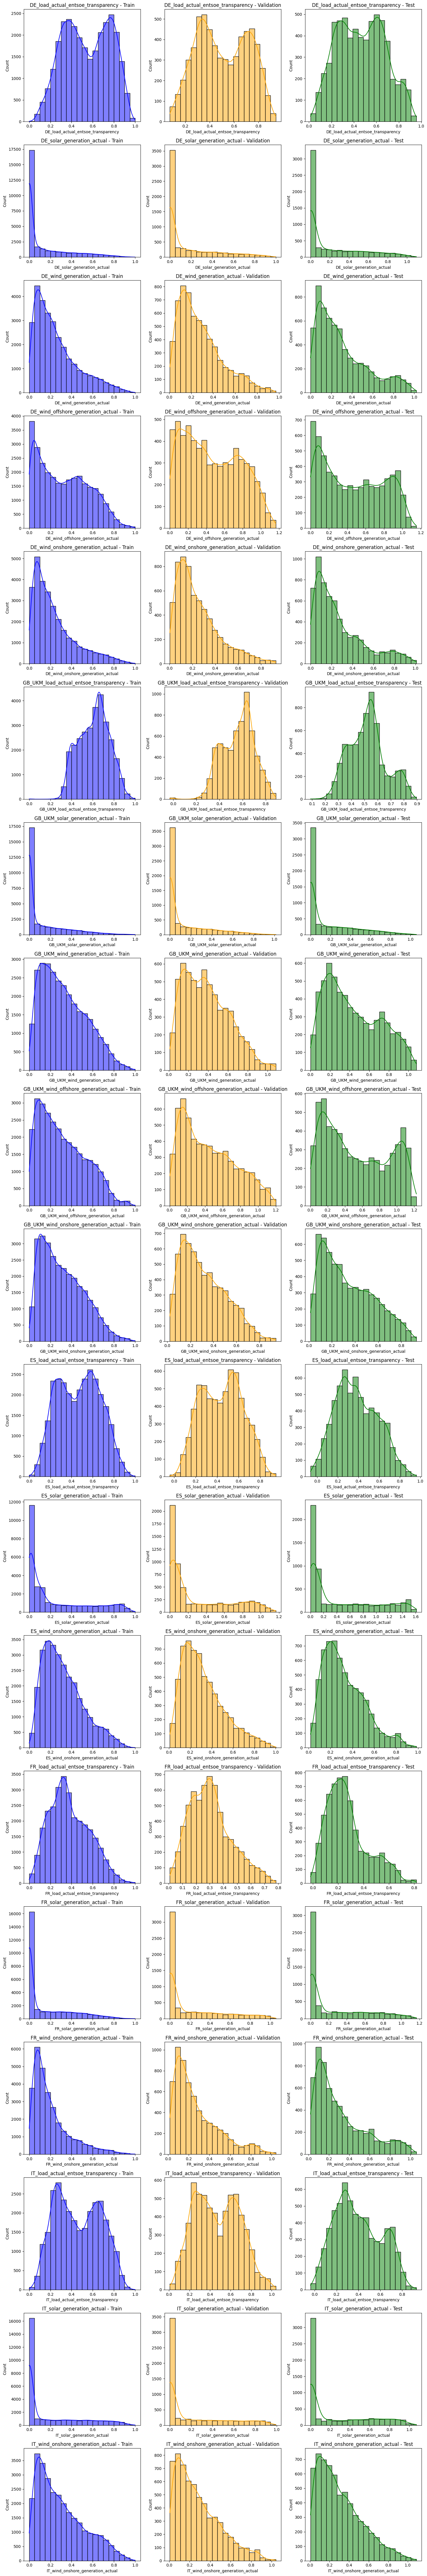

In [37]:
fig, axes = plt.subplots(nrows=19, ncols=3, figsize=(15, 90))
fig.subplots_adjust(hspace=0.5)

for idx, col in enumerate(train.columns):
    # Plot the train set
    sns.histplot(train[col], kde=True, ax=axes[idx, 0], color="blue", bins=20)
    axes[idx, 0].set_title(f"{col} - Train")
    
    # Plot the validation set
    sns.histplot(vali[col], kde=True, ax=axes[idx, 1], color="orange", bins=20)
    axes[idx, 1].set_title(f"{col} - Validation")
    
    # Plot the test set
    sns.histplot(test[col], kde=True, ax=axes[idx, 2], color="green", bins=20)
    axes[idx, 2].set_title(f"{col} - Test")

plt.tight_layout()
plt.show()


In [36]:
combined_df.to_csv("./datasets/combined_data.csv")